In [5]:
import math
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import datetime
from statsmodels import robust
import matplotlib as mpl
from matplotlib import gridspec
import pylab
from matplotlib import cm
from pytz import timezone
import Analysis
from scipy.stats import norm

A function to determine the values for each pixel in the image, and from there to determine the ideal threshohold value. To be automated after the code works for a sample of 6 images

Make it a gaussian and take where two standard deviations away would be
Also try finding where the slope goes from negative to positive

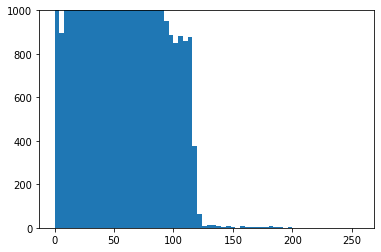

29423.529166666667

In [67]:
img = cv2.imread("20191026_093748_Snap.png",0)

plt.hist(img.ravel(),64,[0,256]); plt.ylim(0,1000); plt.show()

Sum = np.sum(img)

Length = len(img)

Sum/Length
#cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]]) This is the raw function before values inputed

#cv2.calcHist([img], [0], None, [256], [0,256])

color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

The threshold value of this image is: 56.05376017512417


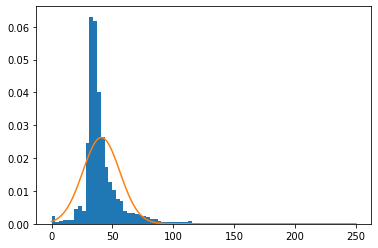

In [74]:
list = img.ravel()

def Gaussian(x,x0,sig):
    y= (1/(np.sqrt(2*np.pi)*sig))*np.exp(-(x-x0)**2/2/sig**2)
    return(y)
plt.hist(list,bins = 64,density=True)
xlist = np.arange(0,250,0.01)
ylist = Gaussian(xlist,np.mean(list),np.std(list))
plt.plot(xlist,ylist)
value = np.mean(list)+np.std(list)
print("The threshold value of this image is:",value)

In [75]:
Cloudmap = img
kernel = np.ones((1,1),np.uint8)


ret,threshCloud = cv2.threshold(Cloudmap,value,255,cv2.THRESH_BINARY_INV)
threshCloudOpen = cv2.morphologyEx(threshCloud, cv2.MORPH_OPEN, kernel)
threshCloudFinal = cv2.morphologyEx(threshCloudOpen, cv2.MORPH_CLOSE, kernel)
cv2.imshow("Threshcloud", threshCloudFinal)
cv2.waitKey(0)
cv2.destroyAllWindows()